# Colab Setup

This segment of code is used to setup the environment when the notebook is run on colab. When running on a local system nothing happens here.

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False


if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  import os
  os.chdir('/content/drive/MyDrive/ModernCV/Assn1/')

# Importing Required Libraries

The following sets of libraries have been imported to be used throughout the notebook:

In [51]:
# Basic python libraries to perform auxiliary tasks
import os
import time
import itertools
import numpy as np
from tqdm import tqdm 
from random import shuffle

# Basic Pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# specific pytorch functions and tools used in the notebook
from torch import flatten
from torch import permute
from torch.nn import ReLU
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import Dropout
from torch.nn import Softmax
from torch.nn import MaxPool2d
from torch.nn import LogSoftmax
from torch.nn import BatchNorm1d, BatchNorm2d
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import SGD, lr_scheduler
from torch.nn import MSELoss, CrossEntropyLoss

# Torchvision to import the CIFAR10 dataset
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from torchvision.datasets import CIFAR10
from torchsummary import summary

# Plotting tools to print model training metrics
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

We now check whether or not a **CUDA enabled GPU** is available as part of the computing resources. CUDA (or Compute Unified Device Architecture) is a parallel computing platform and application programming interface (API) that allows software to use certain types of graphics processing units (GPUs) for general purpose processing. It was developed by NVIDIA and almost all NVIDIA GPUs support CUDA. Training deep learning and tensor-related tasks on GPUs is ideal since CUDA helps a processing task make full use of the parallel processing power of a GPU to allow fast computation.

Pytorch allows us to use the GPU for computation if we set the device to be 'cuda'.

In [3]:
if torch.cuda.is_available(): 
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

# Dataset 

The **CIFAR-10** dataset (**Canadian Institute For Advanced Research**) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 **32x32** color images in **10 different classes**. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

We set the **10%** of the training images to be a part of the **validation set**. We also use a **batch size** of **8** for the training process.

We also define the **normalization** transform for the CIFAR10 images by using the true mean and true standard deviation of the dataset images across the three channels. A similar inverse normalization transform is also used to ensure ease of printing the images. 

In [4]:
batch_size = 8
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.491, 0.482 ,0.446), (0.247, 0.243, 0.262))])
inv_transform = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.247, 1/0.243, 1/0.262 ]), 
                                    transforms.Normalize(mean = [ -0.491, -0.482, -0.446 ], std = [ 1., 1., 1. ])])
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

val_split = 0.10
random_seed = 42

We download the CIFAR10 training set images and then sample the images for the validation set randomly using the **SubsetRandomSampler** function. We set the dataloader functions accordingly to load these randomly picked subsets of images.

In [5]:
trainset = CIFAR10(root = './data', train = True, download = True, transform = transform)
valset = CIFAR10(root = './data', train = True, download = True, transform = transform)

num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(val_split * num_train))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = DataLoader( trainset, batch_size = batch_size, sampler = train_sampler, num_workers = 2)
validloader = DataLoader( valset, batch_size = batch_size, sampler = valid_sampler, num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


Similarly we also download the testset of the CIFAR10 dataset and prepare the **testloader**. 

In [6]:
testset = CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers = 2)

Files already downloaded and verified


Here we define the **imshow()** function which can print an image after **inverting the normalization** applied on the image while loading the dataset and converting the tensor image into a numpy image.

In [7]:
def imshow(img):
    img = inv_transform(img)
    plt.imshow(np.transpose(img.numpy(), (1,2,0)))
    plt.show

Printing 8 examples of the training set with labels (row major order). 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog car ship horse deer frog cat horse


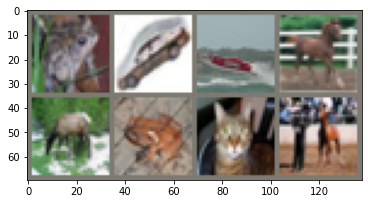

In [8]:
tr_iter = iter(trainloader)
images, labels = next(tr_iter)
imshow(torchvision.utils.make_grid(images, nrow = 4))
print(' '.join(classes[labels[j]] for j in range(batch_size)))

Printing 8 examples of the validation set with labels (row major order). 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog cat frog ship frog ship bird deer


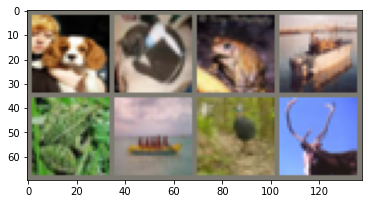

In [9]:
vl_iter = iter(validloader)
images, labels = next(vl_iter)
imshow(torchvision.utils.make_grid(images, nrow = 4))
print(' '.join(classes[labels[j]] for j in range(batch_size)))

Printing 8 examples of the test set with labels (row major order). 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog horse horse frog truck dog ship car


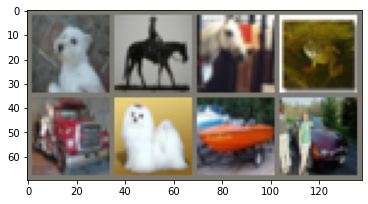

In [10]:
te_iter = iter(testloader)
images, labels = next(te_iter)
imshow(torchvision.utils.make_grid(images, nrow = 4))
print(' '.join(classes[labels[j]] for j in range(batch_size)))

# Helper Functions

Now we define the following functions to aid in the printing of the various metrics to evaluate the performance of the model and to visualize it better. 

- **loss_acc_plotter()** - Plotting the loss and accuracy history curve across epochs
- **get_all_preds()** - Runs the inputs through the trained model and gets all the predictions
- **get_num_correct()** - Takes in the predictions and the labels and outputs how many of the predictions are correct
- **plot_confusion_matrix()** - Takes in the predictions and the labels and then outputs the confusion matrix

In [11]:
def loss_acc_plotter(loss_history, name, title, ax):
    epochs = list(range(len(loss_history)))
    sns.lineplot(x = epochs, y = loss_history, label = name, ax = ax)

    ax.set_title(title, fontweight = 'bold')
    ax.set_ylabel('Loss', fontweight = 'bold')
    ax.set_xlabel('Epoch', fontweight = 'bold')

    return ax

In [12]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        preds = model(images)
        
        all_preds = torch.cat((all_preds, preds), dim = 0)
        all_labels = torch.cat((all_labels, labels), dim = 0)
    return all_preds, all_labels

In [13]:
def get_num_correct(preds, labels):
    return preds.argmax(dim = 1).eq(labels).sum().item()

In [14]:
def plot_confusion_matrix(model, loader, title='Confusion matrix', cmap=plt.cm.Blues):
    
    preds, true_labels = get_all_preds(model, loader)
    preds_correct = get_num_correct(preds, true_labels)
    
    accuracy = preds_correct / len(true_labels)
    preds = preds.cpu()
    true_labels = true_labels.cpu()
    cm = confusion_matrix(true_labels, preds.argmax(dim=1))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontweight = 'bold')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontdict={'weight':'bold'})
    plt.xlabel('Predicted label', fontdict={'weight':'bold'})
    plt.text(x = 3.68, y = -1.2 , s = 'Accuracy: {:.2f}%'.format(accuracy * 100), fontsize = 14, horizontalalignment = 'center')

# Training Loop

In [15]:
MAX_EPOCHS = 50             # sets the default value for MAX_EPOCHS

Here we create dictionaries holding all the dataloaders and the dataset lengths. This is done to allow us to use a loop for printing various matrix across the training, validation and test datasets. 

In [16]:
dataloaders = {'train': trainloader, 'val': validloader, 'test': testloader}
datasetlen = {'train': int(len(trainset) * (1-val_split)), 'val': int(len(trainset) * val_split), 'test': len(testset)}

Here we define the training loop to train the models in this notebook. Both training and validation phases have been dealt with by means of a simple for loop to avoid the code block being too lengthy. 

In [17]:
def train_model(model, criterion, optimizer, scheduler = None, num_epochs = MAX_EPOCHS):
    start = time.time()
    
    # to track training and validation loss and accuracy histories
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        
        # keeps trqack of the running loss
        running_loss = 0.0
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train': model.train() 
            else: model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                
                # send inputs, labels and weights to CUDA device
                inputs = inputs.to(device)
                labels = labels.to(device)
                model = model.to(device)

                # zero the gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # get model predictions and calculate the loss
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # calculate the gradients if in training phase
                    # make a step in that direction using the optimizer
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # update the running loss
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
           
            # decay the LR based on the scheduler
            if phase == 'train': scheduler.step()

            # calculate the epoch loss and accuracy
            epoch_loss = running_loss / datasetlen[phase]
            epoch_acc = running_corrects.double()/ datasetlen[phase]
            
            # append to the loss and accuracy histories
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc.item())
                    
            # print the loss and accuracy
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
    # print the time elapsed in training
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    # return the model, loss and accuracy histories
    return model, losses, accuracies

# Multi-Layer Perceptron (MLP) Model

Here we define a **Multi-Layer Perceptron (MLP)** model with the following layers:

- **Input Layer** which takes in the 3072 flattened inputs of the CIFAR10 images 
- **Hidden Layer 1** - With 500 neurons (fully connected layer)
- **Hidden Layer 2** - With 250 neurons (fully connected layer)
- **Hidden Layer 3** - With 100 neurons (fully connected layer)
- **Output Layer** - With 10 layers (fully connected layer)
- **Softmax Layer** - Takes in the outputs of the model and outputs class probabilities

The activation function used in all the linear (fully connected layers) is the **ReLU (Rectified Linear Unit)** activation function. We also experiment with batch normalisation (results discussed in report).

In [18]:
class MLP(Module):
    def __init__(self):
        super().__init__()
        self.h1 = Linear(in_features = 3072 , out_features=500)
        self.bn1 = BatchNorm1d(500)
        self.relu1 = ReLU()
        self.h2 = Linear(in_features=500, out_features=250)
        self.bn2 = BatchNorm1d(250)
        self.relu2 = ReLU()
        self.h3 = Linear(in_features=250, out_features=100)
        self.bn3 = BatchNorm1d(100)
        self.relu3 = ReLU()
        self.op = Linear(in_features=100, out_features=10)
        self.sm = LogSoftmax(dim = -1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = x # input layer

        # Hidden Layer 1
        x = self.h1(x)
#         x = self.bn1(x)
        x = self.relu1(x)

        # Hidden Layer 2
        x = self.h2(x)
#         x = self.bn2(x)
        x = self.relu2(x)

        # hidden layer 3
        x = self.h3(x) 
#         x = self.bn3(x)
        x = self.relu3(x) 

        # O/P layer with Softmax
        x = self.op(x)
        x = self.sm(x)

        return x

# Model Training (MLP)

We use the following values for the common hyperparameters:
- **Batch Size**: 64 images per batch
- **Initial learning rate $(\alpha)$**: 
The MLP model is trained for 25 epochs and the results have been reported. 

In [86]:
batch_size_mlp = 64
learning_rate_mlp = 0.001
num_epochs_mlp = 25

We print out the summary of the model using the **torchsummary.summary()** function. We also use the **SGD optimizer** with a momentum value of 0.9 for the training. 

Further more we also decay the learning rate by a factor of **0.5** after every **8** epochs. 

In [87]:
mlp = MLP().to(device)
summary(mlp, (3,32,32))

loss_function_mlp = CrossEntropyLoss()
optimizer_mlp = SGD(mlp.parameters(), lr = learning_rate_mlp, momentum=0.9)

# Decay LR by a factor of 0.5 every 8 epochs
exp_lr_scheduler_mlp = lr_scheduler.StepLR(optimizer_mlp, step_size = 8, gamma = 0.5, verbose = True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]       1,536,500
              ReLU-2                  [-1, 500]               0
            Linear-3                  [-1, 250]         125,250
              ReLU-4                  [-1, 250]               0
            Linear-5                  [-1, 100]          25,100
              ReLU-6                  [-1, 100]               0
            Linear-7                   [-1, 10]           1,010
        LogSoftmax-8                   [-1, 10]               0
Total params: 1,687,860
Trainable params: 1,687,860
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 6.44
Estimated Total Size (MB): 6.46
----------------------------------------------------------------
Adjusting learning rate of group 0 to 

Here we carry out the training of the model.

In [88]:
mlp, losses_mlp, accuracies_mlp = train_model(mlp, loss_function_mlp, optimizer_mlp, exp_lr_scheduler_mlp, num_epochs_mlp)

Epoch 1/25
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 1.7205 Acc: 0.3852
val Loss: 1.5746 Acc: 0.4448
Epoch 2/25
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 1.4556 Acc: 0.4843
val Loss: 1.4527 Acc: 0.4800
Epoch 3/25
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 1.3366 Acc: 0.5273
val Loss: 1.4213 Acc: 0.5002
Epoch 4/25
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 1.2477 Acc: 0.5604
val Loss: 1.3759 Acc: 0.5224
Epoch 5/25
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 1.1667 Acc: 0.5869
val Loss: 1.3655 Acc: 0.5258
Epoch 6/25
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 1.0951 Acc: 0.6102
val Loss: 1.3693 Acc: 0.5232
Epoch 7/25
----------
Adjusting learning rate of group 0 to 1.0000e-03.
train Loss: 1.0293 Acc: 0.6358
val Loss: 1.4001 Acc: 0.5294
Epoch 8/25
----------
Adjusting learning rate of group 0 to 5.0000e-04.
trai

## Model Metrics (MLP)

We print the loss and accuracy curves for both the training and the validations sets here.

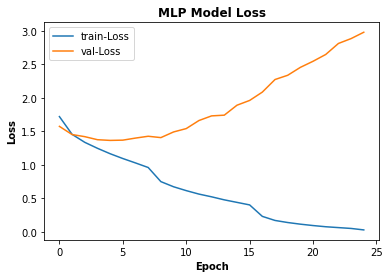

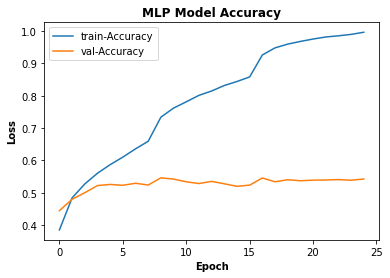

In [89]:
for p, p_name in zip([losses_mlp, accuracies_mlp], ['Loss', 'Accuracy']):
    for phase in ['train', 'val']:
        loss_acc_plotter(p[phase], name = f'{phase}-{p_name}', title = f'MLP Model {p_name}', ax = plt.gca())
    plt.savefig('./plots/mlp/'+p_name+'.png')
    plt.show()

Here we print out the **confusion matrix** for the training, validation and the test datasets along  with the overall acuuracy values obtained on the set.

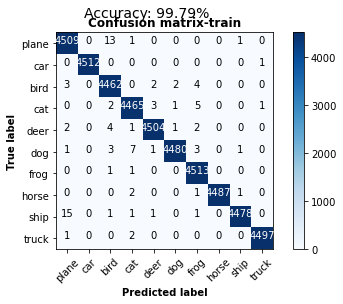

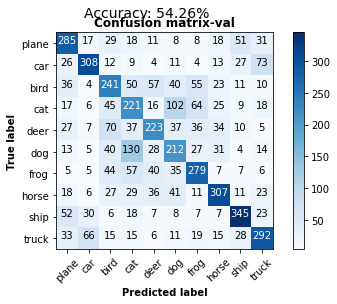

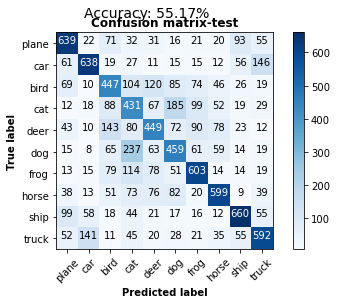

In [90]:
for dset_name in ['train', 'val', 'test']:
  plot_confusion_matrix(mlp, dataloaders[dset_name], title=f'Confusion matrix-{dset_name}', cmap=plt.cm.Blues)
  plt.savefig(f'plots/mlp/cm_'+dset_name+'.png')
  plt.show()

# Visualizing the Predictions (MLP)

Here we output the predictions, true labels and the images for a few random samples of the test dataset. Since testloader is already shuffled we can just take the first batch and print for simplicity.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Labels
cat car plane truck dog horse truck ship
Predictions
dog car plane car dog horse truck ship


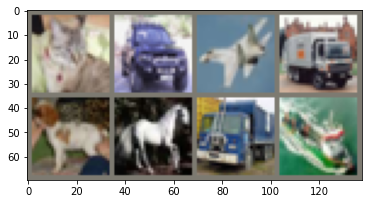

In [112]:
te_iter = iter(testloader)
images, labels = next(te_iter)
images = images.to(device)
labels = labels.to(device)
_, preds = torch.max(mlp(images), 1)
imshow(torchvision.utils.make_grid(images.cpu(), nrow = 4))
print('True Labels')
print(' '.join(classes[labels[j]] for j in range(batch_size)))
print('Predictions')
print(' '.join(classes[preds[j]] for j in range(batch_size)))

# CNN based model - VGG11 Architecture

The **VGG11** architecture was proposed by the **Visual Geometry Group** at Oxford University in the paper: https://arxiv.org/pdf/1409.1556.pdf and is a CNN based deep neural network that performs extremely well on image classification and object localisation tasks. The structure of the model is as given below:

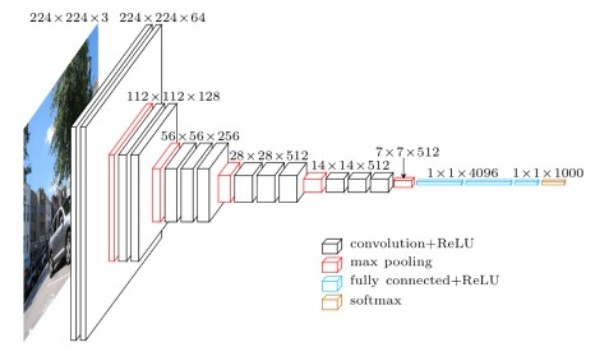

In [21]:
class VGG11(Module):
    def __init__(self, in_channels = 3, num_classes = 10):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        
        self.conv1 = Conv2d(self.in_channels, 64, kernel_size = 3, padding = 1)
        self.relu1 = ReLU()
        self.bn1 = BatchNorm2d(64)
        self.pool1 = MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv2 = Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.relu2 = ReLU()
        self.bn2 = BatchNorm2d(128)
        self.pool2 = MaxPool2d(kernel_size = 2, stride = 2) 
        
        self.conv3 = Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.relu3 = ReLU()
        self.bn3 = BatchNorm2d(256)
        self.conv4 = Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.relu4 = ReLU()
        self.bn4 = BatchNorm2d(256)
        self.pool3 = MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv5 = Conv2d(256, 512, kernel_size = 3, padding = 1)
        self.relu5 = ReLU()
        self.bn5 = BatchNorm2d(512)
        self.conv6 = Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.relu6 = ReLU()
        self.bn6 = BatchNorm2d(512)
        self.pool4 = MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv7 = Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.relu7 = ReLU()
        self.bn7 = BatchNorm2d(512)
        self.conv8 = Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.relu8 = ReLU()
        self.bn8 = BatchNorm2d(512)
        self.pool5 = MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = Linear(in_features = 512, out_features = 4096)
        self.relu9 = ReLU()
        self.fc2 = Linear(in_features = 4096, out_features = 4096)
        self.relu10 = ReLU()
        self.fc3 = Linear(in_features = 512, out_features = self.num_classes)
        
        self.sm = LogSoftmax(dim = -1)

    def forward(self, x):
        
        # convolutional layers 
        x = self.relu1(self.bn1(self.conv1(x)))  # conv layer 1
        x = self.pool1(x)                        # max pool layer 1
        x = self.relu2(self.bn2(self.conv2(x)))  # conv layer 2
        x = self.pool2(x)                        # maxpool layer 2
        x = self.relu3(self.bn3(self.conv3(x)))  # conv layer 3
        x = self.relu4(self.bn4(self.conv4(x)))  # conv layer 4
        x = self.pool3(x)                        # maxpool layer 3
        x = self.relu5(self.bn5(self.conv5(x)))  # conv layer 5
        x = self.relu6(self.bn6(self.conv6(x)))  # conv layer 6
        x = self.pool4(x)                        # maxpool layer 4
        x = self.relu7(self.bn7(self.conv7(x)))  # conv layer 7
        x = self.relu8(self.bn8(self.conv8(x)))  # conv layer 8
        x = self.pool5(x)                        # maxpool layer 5

        # flattening the input
        x = flatten(x, 1)
        
        # fully connected layers
#         x = self.relu9(self.fc1(x))    # dense layer 1
#         x = self.relu10(self.fc2(x))   # dense layer 2
        x = self.fc3(x)                # dense layer 3
        
        # softmax layer
        x = self.sm(x)

        return x

# Model Training (VGG11)

We use the following values for the common hyperparameters:
- **Batch Size**: 64
- **Initial learning rate $(\alpha)$**: 
The MLP model is trained for 25 epochs and the results have been reported. 

In [24]:
batch_size_vgg = 64
learning_rate_vgg = 0.01
num_epochs_vgg = 15

We print out the summary of the model using the **torchsummary.summary()** function. We also use the **SGD optimizer** with a momentum value of 0.9 for the training. 

Here we do not decay the learning rate unlike in the case of MLP. 

In [25]:
vgg = VGG11().to(device)
summary(vgg, (3,32,32))

loss_function_vgg = CrossEntropyLoss()
optimizer_vgg = SGD(vgg.parameters(), lr = learning_rate_vgg, momentum=0.9)

# don't decay LR (gamma = 1)
exp_lr_scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size = 5, gamma = 1, verbose = True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

Here we carry out the training of the model.

In [26]:
vgg, losses_vgg, accuracies_vgg = train_model(vgg, loss_function_vgg, optimizer_vgg, exp_lr_scheduler_vgg, num_epochs_vgg)

Epoch 1/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 1.8544 Acc: 0.3110
val Loss: 1.3730 Acc: 0.4850
Epoch 2/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 1.2146 Acc: 0.5662
val Loss: 0.9932 Acc: 0.6512
Epoch 3/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 0.9154 Acc: 0.6795
val Loss: 0.7803 Acc: 0.7252
Epoch 4/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 0.7424 Acc: 0.7402
val Loss: 0.7234 Acc: 0.7492
Epoch 5/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 0.6138 Acc: 0.7872
val Loss: 0.6974 Acc: 0.7576
Epoch 6/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 0.5059 Acc: 0.8264
val Loss: 0.5985 Acc: 0.7936
Epoch 7/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.
train Loss: 0.4163 Acc: 0.8566
val Loss: 0.6114 Acc: 0.7982
Epoch 8/15
----------
Adjusting learning rate of group 0 to 1.0000e-02.
trai

# Model Metrics (VGG11)

We print the loss and accuracy curves for both the training and the validations sets here.

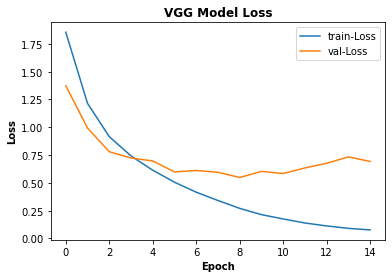

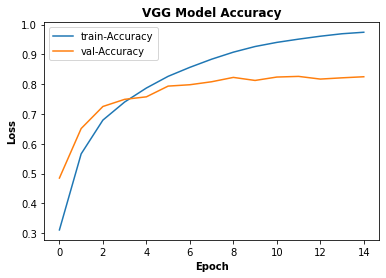

In [28]:
for p, p_name in zip([losses_vgg, accuracies_vgg], ['Loss', 'Accuracy']):
    for phase in ['train', 'val']:
        loss_acc_plotter(p[phase], name = f'{phase}-{p_name}', title = f'VGG Model {p_name}', ax = plt.gca())
    plt.savefig('./plots/vgg/'+p_name+'_nfc_1e2_15.png')
    plt.show()

Here we print out the **confusion matrix** for the training, validation and the test datasets along  with the overall acuuracy values obtained on the set.

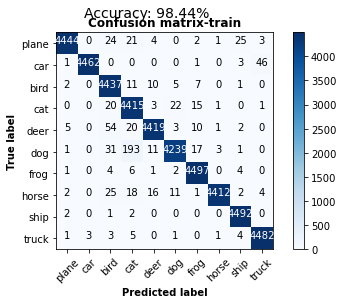

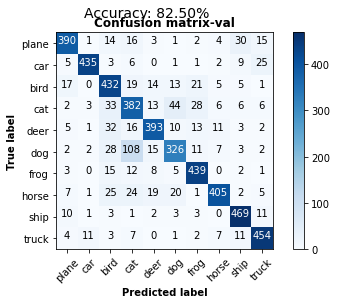

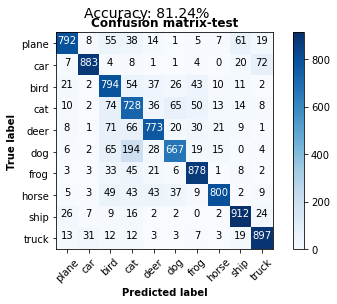

In [30]:
for dset_name in ['train', 'val', 'test']:
  plot_confusion_matrix(vgg, dataloaders[dset_name], title=f'Confusion matrix-{dset_name}', cmap=plt.cm.Blues)
  plt.savefig(f'plots/vgg/cm_'+dset_name+'_nfc_1e2_15.png')
  plt.show()

# Visualizing the Predictions (VGG)

Here we output the predictions, true labels and the images for a few random samples of the test dataset. Since testloader is already shuffled we can just take the first batch and print for simplicity.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Labels
truck truck truck deer ship plane truck truck
Predictions
truck truck truck deer ship plane truck truck


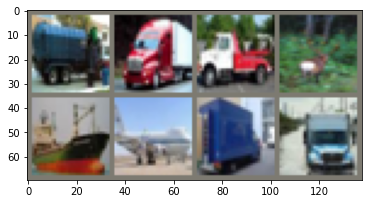

In [31]:
te_iter = iter(testloader)
images, labels = next(te_iter)
images = images.to(device)
labels = labels.to(device)
_, preds = torch.max(vgg(images), 1)
imshow(torchvision.utils.make_grid(images.cpu(), nrow = 4))
print('True Labels')
print(' '.join(classes[labels[j]] for j in range(batch_size)))
print('Predictions')
print(' '.join(classes[preds[j]] for j in range(batch_size)))

# Testing on Fresh Images 

We now test our trained model on 32x32 images from the internet. In order to resize higher resolution images into 32x32 pixels we use the online tool https://safeimagekit.com/. We have tested the model on some images.. The images have been prepared such that the names of the images are the corresponding indexes of the class as per the CIFAR dataset. Thus there is no need to have a further annotated file with label information given. The results are given below.

In [81]:
class mockCIFAR(Dataset):
    def __init__(self, number, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.length = number

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.root_dir + '/' + str(idx+1) + '.png'
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, idx

In [82]:
def test_image(model, imgs, labels, batch_size):
    imgs = imgs.to(device)
    labels = labels.to(device)
    _, preds = torch.max(model(imgs), 1)
    imshow(torchvision.utils.make_grid(imgs.cpu(), nrow = 5))
    print('True Labels')
    print(' '.join(classes[labels[j]] for j in range(batch_size)))
    print('Predictions')
    print(' '.join(classes[preds[j]] for j in range(batch_size)))
    return 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Labels
bird cat dog ship truck car frog deer horse plane
Predictions
bird cat dog ship truck truck frog deer dog plane


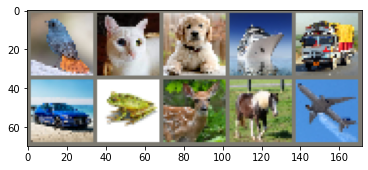

In [83]:
batch_size_tst = 10
customloader = DataLoader(mockCIFAR(10, './test/', transform), batch_size = batch_size_tst, shuffle = True)
custom_iter = iter(customloader)
imgs, labels = next(custom_iter)
test_image(vgg, imgs, labels, batch_size_tst)

# Device Information

In [46]:
# this prints GPU information
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Tue Sep 20 19:11:34 2022
Driver Version                            : 512.78
CUDA Version                              : 11.6

Attached GPUs                             : 1
GPU 00000000:01:00.0
    Product Name                          : NVIDIA GeForce RTX 3050 Laptop GPU
    Product Brand                         : GeForce
    Product Architecture                  : Ampere
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : N/A
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : WDDM
        Pending                           : WDDM
    Serial Number                         : N/A
    GPU UUID 